# Vanilla DQN

I lernt from the following websites to finish the implementations.
Reference:
1. Hung-yi Lee. DRL Lecture 3: Q-learning (Basic Idea)
https://youtu.be/o_g9JUMw1Oc
2. Hung-yi Lee. DRL Lecture 4: Q-learning (Advanced Tips)
https://www.youtube.com/watch?v=2-zGCx4iv_k&t=980s
3. Tensorflow
https://www.tensorflow.org/api_docs/python/tf/keras/Model
4. Tom. Let's build a DQN: simple implementation
https://tomroth.com.au/dqn-simple/

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
from random import sample

# Setting up the environment 
env = gym.make("CartPole-v0")

In [2]:
def create_model(name):
    input_layer = tf.keras.Input(shape = (4,))
    H1 = tf.keras.layers.Dense(32, activation='relu')(input_layer)
    H3 = tf.keras.layers.Dense(16, activation='relu')(H1)
    output_layer = tf.keras.layers.Dense(2)(H3)
    model = tf.keras.Model(inputs = input_layer, outputs = output_layer,name = name)
    model.compile(optimizer='adam',
                  loss="mse",
                  metrics=['accuracy'])
    model.summary()
    return model
model = create_model(name = "QNN")
# Target network
model2 = create_model(name = "TagretNetwork")



def replay(buffer, minibatch_size,timestep,epsoide_num):
    if timestep <= 500:
        return model
    else:
        minibatch = np.random.choice(buffer, minibatch_size, replace=False)
        s_l =      np.array(list(map(lambda x: x['s'], minibatch)))
        a_l =      np.array(list(map(lambda x: x['a'], minibatch)))
        r_l =      np.array(list(map(lambda x: x['r'], minibatch)))
        sprime_l = np.array(list(map(lambda x: x['sprime'], minibatch)))
        done_l   = np.array(list(map(lambda x: x['done'], minibatch)))
        current_qs = model.predict(s_l)
        Q_tgt = model2.predict(sprime_l)

        if epsoide_num % 10 == 0 and epsoide_num != 0:
            model2.set_weights(model.get_weights())   
        # q-update

        for i,(s,a,r,done,sprimeTgt) in enumerate(zip(s_l,a_l,r_l,done_l,Q_tgt)):
            if not done:  target = r + np.max(sprimeTgt)
            else:         target = r
            # Update Q value for given state
            current_qs[i][a] = target
            # And append to our training data
        model.fit(s_l,current_qs,batch_size = minibatch_size,epochs=1,verbose=0)
        return model

Model: "QNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________
Model: "TagretNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
__________________________________________

In [3]:
from random import randrange

# hyper parameter
n_episodes = 2500
epsilon = 0.9
minibatch_size = 32
r_sums = []  # stores rewards of each epsiode 
buffer = [] # replay memory holds s, a, r, s'
win_weight_eps_tstep = []
mem_max_size = 10000
init_seed=123
timestep = 0
eps = 0
np.random.seed(123)


for n in range(n_episodes): 
    env.seed(seed=init_seed+n)
    s = env.reset()
    done=False
    r_sum = 0
    while not done: 
        # Uncomment this to see the agent learning
        # env.render()
        # Feedforward pass for current state to get predicted q-values for all actions 
        qvals_s = model.predict(s.reshape(1,4))
        # Choose action to be epsilon-greedy
        if np.random.random() < epsilon:  
            a = randrange(1)
        else:                             
            a = np.argmax(qvals_s)
        # Take step, store results 
        sprime, r, done, info = env.step(a)
        r_sum += r 
        # add to memory, respecting memory buffer limit 
        if len(buffer) > mem_max_size:
            buffer.pop(0)
        buffer.append({"s":s,"a":a,"r":r,"sprime":sprime,"done":done})
        # Update state
        s=sprime
        # Train the nnet that approximates q(s,a), using the replay memory
        model=replay(buffer, minibatch_size = minibatch_size, timestep = timestep, epsoide_num = n)
        # Decrease epsilon until we hit a target threshold 
        timestep += 1
        if timestep % 1000 == 0 and timestep != 0:
            print("timestep",timestep)   
    epsilon -= 0.001
    if epsilon <= 0.0005:
        eps += 0.001
        epsilon = 0.001
        if eps == 0.001:
            print("In the timestep of ", timestep, ", epsilon is fixed at",epsilon)     
    #print("Total reward:", r_sum)
    r_sums.append(r_sum)
    if n % 100 == 0 and n != 0: 
        print(n,"\n")
        print("r_score", np.round(np.mean(np.array(r_sums)), 3), "±", 2*np.round(np.std(np.array(r_sums)), 3), n+1, "trials. \n")
        print("rsums_lastest100",r_sums[-10:],"\n")

timestep 1000
100 

r_score 10.139 ± 2.898 101 trials. 

rsums_lastest100 [10.0, 10.0, 9.0, 9.0, 8.0, 11.0, 11.0, 10.0, 9.0, 10.0] 

timestep 2000
200 

r_score 12.144 ± 11.058 201 trials. 

rsums_lastest100 [11.0, 41.0, 10.0, 14.0, 44.0, 17.0, 13.0, 11.0, 18.0, 10.0] 

timestep 3000
timestep 4000
300 

r_score 14.302 ± 15.192 301 trials. 

rsums_lastest100 [17.0, 28.0, 9.0, 15.0, 18.0, 16.0, 33.0, 19.0, 20.0, 28.0] 

timestep 5000
timestep 6000
timestep 7000
400 

r_score 17.88 ± 24.86 401 trials. 

rsums_lastest100 [25.0, 25.0, 15.0, 42.0, 19.0, 56.0, 13.0, 20.0, 12.0, 21.0] 

timestep 8000
timestep 9000
timestep 10000
500 

r_score 21.327 ± 34.382 501 trials. 

rsums_lastest100 [58.0, 28.0, 52.0, 19.0, 64.0, 18.0, 22.0, 44.0, 19.0, 11.0] 

timestep 11000
timestep 12000
timestep 13000
timestep 14000
timestep 15000
600 

r_score 25.153 ± 42.836 601 trials. 

rsums_lastest100 [16.0, 93.0, 37.0, 92.0, 43.0, 29.0, 84.0, 79.0, 94.0, 36.0] 

timestep 16000
timestep 17000
timestep 18000
tim

timestep 319000
timestep 320000
timestep 321000
timestep 322000
timestep 323000
timestep 324000
timestep 325000
timestep 326000
timestep 327000
timestep 328000
timestep 329000
timestep 330000


Text(0, 0.5, 'Reward')

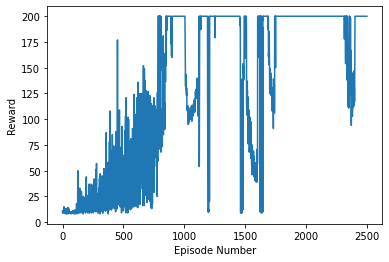

In [4]:
# Plot the performance of the agent 
plt.plot(r_sums)
plt.xlabel("Episode Number")
plt.ylabel("Reward")

In [5]:
import pickle
# Store data (serialize)
with open('cartpole_NDQN_final.pickle', 'wb') as handle:
    pickle.dump(r_sums +[timestep,], handle)

with open('cartpole_NDQN_final.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [7]:
len(b)
b[-1]

330262